# Model

This model is build to work with data from multiple datasets that have been processed to 112x112 size.

## Imports and information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
from functools import partial
from random import randint

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
## WWMR data paths
mlfw_X_fp = r'D:\data\face_mask\MLFW\MLFW_X.npy'
mlfw_y_fp = r'D:\data\face_mask\MLFW\MLFW_y.npy'

## Build data loader

In [3]:
class maskDataset(Dataset):
    def __init__(
        self,
        X_data,
        y_data,
        norm_0_1: bool = True,
        print_stats: bool = True,
    ):        
        self.X_data = X_data
        
        # Norm
        if norm_0_1:
            self.X = self.X_data / 255
        else:
            self.X = self.X_data
        
        self.y = y_data
        
        self.length = len(self.y)
        
        # Print Stats
        if print_stats:
            print('# examples:    {}'.format(self.length))
            ratio = sum(self.y) / self.length
            print('class balence: {:.2f}'.format(ratio))

        # reshape?? see comment in __getitem__() ?????
        self.X = self.X.reshape((self.length, 3, 112, 112)) 
        
    def __len__(self):
        return self.length
    
   
    def __getitem__(self, index):
        image = self.X[index]
        
        # the input to a conv2d must be in [N, C, W, H] format
        #  n = number of examples, c is channels, w is width, and h is height
        #  This means we do not in fact need to transpose the data. it should
        #  be in the shape (3, 112, 112)
        #image = np.transpose(image)
        #image = np.rot90(image, k=3)
        
        return image.astype(np.float32), torch.tensor(self.y[index]).long()    

In [4]:
# function to concat the various data sets and split into train val test

def merge_split(
    X_data_lists: list,
    y_data_lists: list,
    train=0.7,
    val=0.15,
    test=0.15
):
    if (train + val + test) != 1:
        print('splits must add to 1, added to {}'.format(train + val + test))
        return None
    if train < 0 or val < 0 or test < 0:
        print('splits must be positive')
        return None

    # Concat
    X = np.concatenate(X_data_lists)
    y = np.concatenate(y_data_lists)
    
    # split off test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test, random_state=42)
    
    # split off val
    val_percent_tv = val / (val + train)  # 15 percent of total data is equal to this
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_percent_tv, random_state=42)
    
    return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

### Test data loader

In [5]:
# data file paths
X_fp_list = [mlfw_X_fp]
y_fp_list = [mlfw_y_fp]

X_data_list = [np.load(fp) for fp in X_fp_list]
y_data_list = [np.load(fp) for fp in y_fp_list]

In [6]:
# merge data and split into train val and test
(X_train, y_train), (X_val, y_val), (X_test, y_test) = merge_split(X_data_list, y_data_list)

In [7]:
ds = maskDataset(
    X_data=X_train,
    y_data=y_train,
    norm_0_1=True,
    print_stats=True,
)

# examples:    8399
class balence: 0.75


In [8]:
ds.X.shape

(8399, 3, 112, 112)

In [9]:
ds[2][0].shape

(3, 112, 112)

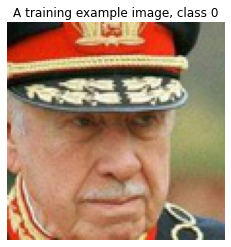

In [10]:
img_idx = randint(0, 8399)

image, label = ds[img_idx]

# un-normalize
image = (image * 255).astype(np.uint8)

# show image
plt.imshow(image.reshape(112, 112, 3))
plt.title('A training example image, class {}'.format(label) )
plt.axis('off')
plt.show()

## Model

The following model is implemented in pytorch. It uses several convotutional layers followed by several linear layers.

In [11]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size: Sequence[int] = (3, 112, 112),
        num_classes: int = 2,
        channels: Sequence[int] = (8, 16, 32),
        kernel_sizes: Sequence[int] = (10, 10, 10, 10),
        linear_units: Sequence[int] = (100, 10),
    ):
        super(CNN, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.channels = input_size[0:1] + channels
        self.kernel_sizes = kernel_sizes
        self.linear_units = linear_units
        
        self.flatten = nn.Flatten()
        self.pool = partial(nn.MaxPool2d, kernel_size=2, stride=2)  # first 2 is for 2x2 kernel, second is stride length
        self.dropout = nn.Dropout
        self.activation = nn.ReLU
        self.accuracy = torchmetrics.functional.accuracy
        self.conf_matrix = torchmetrics.functional.confusion_matrix
        
        # optional, define batch norm here
        
        # build the convolutional layers
        conv_layers = list()
        for in_channels, out_channels, kernel_size in zip(
            self.channels[:-2], self.channels[1:-1], self.kernel_sizes[:-1]
        ):
            conv_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    #stride=2,
                    #padding='same',
                )
            )
            conv_layers.append(self.activation())
            conv_layers.append(self.pool())
        # add final layer to convolutions
        conv_layers.append(
            nn.Conv2d(
                in_channels=self.channels[-2],
                out_channels=self.channels[-1],
                kernel_size=self.kernel_sizes[-1],
                stride=2,
                #padding='same',
            )
        )
        conv_layers.append(self.activation())
        conv_layers.append(self.pool())

        
        # turn list into layers
        self.conv_net = nn.Sequential(*conv_layers)
        
        # linear layers
        linear_layers = list()
        prev_linear_size = self.channels[-1] * 9  # const scale it correctly
        for dense_layer_size in self.linear_units:
            linear_layers.append(
                nn.Linear(
                    in_features=prev_linear_size,
                    out_features=dense_layer_size,
                )
            )
            linear_layers.append(self.activation())
            prev_linear_size=dense_layer_size
            
        self.penultimate_dense = nn.Sequential(*linear_layers)
        self.ultimate_dense = nn.Linear(
            in_features=self.linear_units[-1],
            out_features=self.num_classes
        )
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_net(x)
        x = self.flatten(x)
        # may need to expand dense entry since flatten
        x = self.penultimate_dense(x)
        x = self.ultimate_dense(x)
        return x


def train(dataloader, model, loss_fn, optimizer, verbose=False):
    #model = model.float()  # sometime fixes random obscure type error
    model.train()  # configures for training, grad on, dropout if there is dropout
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # compute prediction loss
        preds = model(X)
        loss = loss_fn(preds, y)
        
        # backprop
        loss.backward()
        optimizer.step()
        
        if batch % 5 == 0 and verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

# for evaluating on validation data too
def test(dataloader, model, loss_fn, verbose=False):
    model.eval()
    test_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for X, y in dataloader:

            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss
        

The below 2 blocks show the structure of the model with the default parameters for the convolution sizes, convolution kernel sizes, and linear layer sizes.

In [12]:
net = CNN()

In [13]:
net

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(10, 10), stride=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (penultimate_dense): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU()
  )
  (ultimate_dense): Linear(in_features=10, out_features=2, bias=True)
)

## Running the model

Running the pytorch model involves several steps. First, the pytorch datasets must be set up. They take in the X and y data at construction to become an object that can serve up the data on command. Next, the pytorch data loaders are created. These data loaders are another pytorch object which takes in the dataset, whether to shuffle or not, and the batch size.

The model, loss function, and optimizer are created next. The training loop follows. This loop runs the training loop defined above with the model and then evaluates on the validation data.

In [16]:
# Create datasets
train_dataset = maskDataset(
    X_data=X_train,
    y_data=y_train,
    norm_0_1=True,
    print_stats=False,
)

val_dataset = maskDataset(
    X_data=X_val,
    y_data=y_val,
    norm_0_1=True,
    print_stats=False,
)

test_dataset = maskDataset(
    X_data=X_test,
    y_data=y_test,
    norm_0_1=True,
    print_stats=False,
)

In [17]:
# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Create CNN
model = CNN()

# use cross entropy loss
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.003,
    momentum=0.9,
    #nesterov =True
    weight_decay =.0001
)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# record results
train_loss = []
val_loss = []
val_accur = []

epochs = 25
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
    train_loss.append(train_l)
    
    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=True)
    val_loss.append(val_l)
    val_accur.append(val_a) 

Using cpu device
Results: 
 Accuracy: 75.7%, Avg loss: 0.556957 

Results: 
 Accuracy: 75.7%, Avg loss: 0.549833 

Results: 
 Accuracy: 75.7%, Avg loss: 0.519702 

Results: 
 Accuracy: 75.7%, Avg loss: 0.334983 

Results: 
 Accuracy: 88.7%, Avg loss: 0.264947 

Results: 
 Accuracy: 93.7%, Avg loss: 0.158517 

Results: 
 Accuracy: 94.2%, Avg loss: 0.136182 

Results: 
 Accuracy: 96.7%, Avg loss: 0.082187 

Results: 
 Accuracy: 96.9%, Avg loss: 0.078342 

Results: 
 Accuracy: 96.6%, Avg loss: 0.071900 

Results: 
 Accuracy: 97.4%, Avg loss: 0.073186 

Results: 
 Accuracy: 97.5%, Avg loss: 0.059025 

Results: 
 Accuracy: 97.3%, Avg loss: 0.060188 

Results: 
 Accuracy: 97.7%, Avg loss: 0.054623 

Results: 
 Accuracy: 96.6%, Avg loss: 0.064278 

Results: 
 Accuracy: 97.4%, Avg loss: 0.058505 

Results: 
 Accuracy: 95.7%, Avg loss: 0.099461 

Results: 
 Accuracy: 97.3%, Avg loss: 0.055437 

Results: 
 Accuracy: 97.7%, Avg loss: 0.057198 

Results: 
 Accuracy: 98.0%, Avg loss: 0.047593 

Res

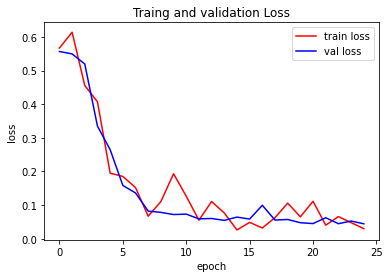

In [20]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation Loss')
plt.show()

In [21]:
# get val predictions and true labels for a classification report
preds = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in val_dataloader:
        pred = model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       437
           1       0.97      1.00      0.99      1364

    accuracy                           0.98      1801
   macro avg       0.98      0.96      0.97      1801
weighted avg       0.98      0.98      0.98      1801



With the current parameters, we get an accuracy of 99% on the validation data and an f1 score of 0.99.

### Optimizer param sweep

Given the high performance, A parameter sweep isn't nessisary.




### Saving the model weights

To reuse the model, we will save the weights. Pytorch offers a very easy way to save model weights. The model itself will be placed into a python file so it can be imported.

In [22]:
weights_fp = './results/torch_model_weights_mlfw_only'
torch.save(model.state_dict(), weights_fp)